In [1]:
import tensorflow
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
DATASET_PATH = "../../data/raw/training.csv"
IMGS_SIZE = (96, 96)
EPOCHS = 200
BATCH_SIZE = 64

Preprocessing data

In [3]:
data = pd.read_csv(DATASET_PATH)
print("before drop na", len(data.index))
data = data.fillna(method="ffill")
print("after drop na", len(data.index))

before drop na 7049
after drop na 7049


In [4]:
img_array = np.array([data['Image'][i].split(' ') for i in range(len(data))], dtype='float')
img_array = np.array([img.reshape(96,96,1) for img in img_array])

In [5]:
keypoints = data.drop(["Image"], axis=1).sort_index()

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(img_array, keypoints, test_size=0.2, shuffle=True)

Get simple convolutional model (val mse 1.28)

In [14]:
input = Input(shape=(96, 96, 1))
x = Conv2D(32, (3, 3), activation="relu")(input)
x = MaxPooling2D()(x)
x = Conv2D(16, (3, 3), activation="relu")(x)
x = MaxPooling2D()(x)
x = Conv2D(8, (3, 3), activation="relu")(x)
x = Flatten()(x)
output = Dense(30, activation="relu")(x)
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 8)         1160

In [15]:
model.compile(optimizer="adam", loss="mean_absolute_error")
vat_acc_checkpoint = ModelCheckpoint(
    "best_simple_model.h5", monitor="val_loss", mode="min", save_best_only=True
)

In [16]:
hostory = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    callbacks=[vat_acc_checkpoint])

Epoch 1/200
89/89 [==============================] - 1s 7ms/step - loss: 10.8251 - val_loss: 8.7994
Epoch 2/200
89/89 [==============================] - 0s 5ms/step - loss: 7.3092 - val_loss: 6.8148
Epoch 3/200
89/89 [==============================] - 0s 5ms/step - loss: 6.9036 - val_loss: 6.6932
Epoch 4/200
89/89 [==============================] - 0s 5ms/step - loss: 6.7848 - val_loss: 6.4644
Epoch 5/200
89/89 [==============================] - 0s 4ms/step - loss: 6.0558 - val_loss: 6.5168
Epoch 6/200
89/89 [==============================] - 0s 5ms/step - loss: 5.8010 - val_loss: 6.2517
Epoch 7/200
89/89 [==============================] - 0s 5ms/step - loss: 5.6300 - val_loss: 5.5254
Epoch 8/200
89/89 [==============================] - 0s 4ms/step - loss: 4.7035 - val_loss: 7.1447
Epoch 9/200
89/89 [==============================] - 0s 5ms/step - loss: 4.9117 - val_loss: 4.1583
Epoch 10/200
89/89 [==============================] - 0s 4ms/step - loss: 3.5426 - val_loss: 6.4050
Epoch 11

In [17]:
model = load_model("best_simple_model.h5")
model.evaluate(X_test, Y_test)

45/45 [==============================] - 0s 2ms/step - loss: 1.2821


1.2820613384246826

Get vgg like model. Val loss 2.4

In [10]:
input = Input(shape=(96, 96, 1))
x = Conv2D(32, (3, 3), activation="relu")(input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D()(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
# x = Dense(5000, activation="relu")(x)
# x = Dense(1000, activation="relu")(x)
output = Dense(30, activation="relu")(x)
vgg_like_model = Model(inputs=input, outputs=output)
vgg_like_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       7385

In [11]:
vgg_like_model.compile(optimizer="adam", loss="mean_absolute_error")
vat_acc_checkpoint = ModelCheckpoint(
    "best_vgg_like_model.h5", monitor="val_loss", mode="min", save_best_only=True
)

In [12]:
hostory = vgg_like_model.fit(X_train,
                                Y_train,
                                validation_data=(X_test, Y_test), 
                                epochs=EPOCHS, 
                                batch_size=BATCH_SIZE,
                                callbacks=[vat_acc_checkpoint])

Epoch 1/200
89/89 [==============================] - 1s 10ms/step - loss: 14.9382 - val_loss: 12.8831
Epoch 2/200
89/89 [==============================] - 1s 8ms/step - loss: 11.2372 - val_loss: 10.4364
Epoch 3/200
89/89 [==============================] - 1s 8ms/step - loss: 11.0329 - val_loss: 10.0709
Epoch 4/200
89/89 [==============================] - 1s 8ms/step - loss: 10.1411 - val_loss: 9.7969
Epoch 5/200
89/89 [==============================] - 1s 8ms/step - loss: 9.4181 - val_loss: 8.7134
Epoch 6/200
89/89 [==============================] - 1s 8ms/step - loss: 6.9690 - val_loss: 6.7183
Epoch 7/200
89/89 [==============================] - 1s 8ms/step - loss: 5.9443 - val_loss: 4.7926
Epoch 8/200
89/89 [==============================] - 1s 8ms/step - loss: 3.8572 - val_loss: 3.4088
Epoch 9/200
89/89 [==============================] - 1s 8ms/step - loss: 3.3124 - val_loss: 3.2653
Epoch 10/200
89/89 [==============================] - 1s 8ms/step - loss: 3.1934 - val_loss: 3.3940
E

In [13]:
model = load_model("best_vgg_like_model.h5")
model.evaluate(X_test, Y_test)

45/45 [==============================] - 0s 2ms/step - loss: 2.4107


2.4107491970062256

ResNetV2 base model. Val loss 0.74

In [14]:
def convert_one_channel_to_three(img):
    tree_chanels = cv2.merge((img, img, img))
    return tree_chanels

In [19]:
three_chanels_train_dataset = np.array([convert_one_channel_to_three(img) for img in X_train])
three_chanels_test_dataset = np.array([convert_one_channel_to_three(img) for img in X_test])

In [23]:
base_model = ResNet50V2(input_shape=(96, 96, 3),
                            include_top=False,
                            weights='imagenet',
                            classifier_activation=None)
inputs = Input(shape=(96, 96, 3))
x = base_model(inputs)
x = MaxPooling2D()(x)
x = Flatten()(x)
output = Dense(30, activation="relu")(x)
res_net_base_model = Model(inputs=inputs, outputs=output)
res_net_base_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 30)                61470     
                                                                 
Total params: 23,626,270
Trainable params: 23,580,830
Non-trainable params: 45,440
__________________________________________

In [24]:
res_net_base_model.compile(optimizer="adam", loss="mean_absolute_error")
vat_acc_checkpoint = ModelCheckpoint(
    "resnet_base_model.h5", monitor="val_loss", mode="min", save_best_only=True
)

In [27]:
hostory = res_net_base_model.fit(three_chanels_train_dataset,
                                    Y_train,
                                    validation_data=(three_chanels_test_dataset, Y_test), 
                                    epochs=EPOCHS, 
                                    batch_size=BATCH_SIZE,
                                    callbacks=[vat_acc_checkpoint])

Epoch 1/200
89/89 [==============================] - 4s 44ms/step - loss: 0.2793 - val_loss: 1.7435
Epoch 2/200
89/89 [==============================] - 4s 40ms/step - loss: 0.3014 - val_loss: 1.4626
Epoch 3/200
89/89 [==============================] - 4s 40ms/step - loss: 0.2913 - val_loss: 1.7316
Epoch 4/200
89/89 [==============================] - 4s 40ms/step - loss: 0.2840 - val_loss: 1.4428
Epoch 5/200
89/89 [==============================] - 4s 40ms/step - loss: 0.2825 - val_loss: 1.4008
Epoch 6/200
89/89 [==============================] - 4s 46ms/step - loss: 0.2734 - val_loss: 0.7744
Epoch 7/200
89/89 [==============================] - 3s 39ms/step - loss: 0.2859 - val_loss: 1.3668
Epoch 8/200
89/89 [==============================] - 3s 39ms/step - loss: 0.2810 - val_loss: 2.4899
Epoch 9/200
89/89 [==============================] - 3s 39ms/step - loss: 0.2865 - val_loss: 1.4332
Epoch 10/200
89/89 [==============================] - 3s 39ms/step - loss: 0.2725 - val_loss: 1.5609

In [30]:
model = load_model("resnet_base_model.h5")
model.evaluate(three_chanels_test_dataset, Y_test)

45/45 [==============================] - 1s 9ms/step - loss: 0.7394


0.739396333694458

In [32]:
pred = model.predict(three_chanels_test_dataset)

45/45 [==============================] - 1s 8ms/step


In [33]:
pred_int = np.array(pred[0], dtype=int)
pred_int

array([63, 37, 29, 40, 59, 36, 73, 34, 37, 39, 22, 40, 53, 29, 81, 27, 38,
       33, 15, 36, 48, 65, 72, 71, 34, 77, 51, 76, 48, 76])

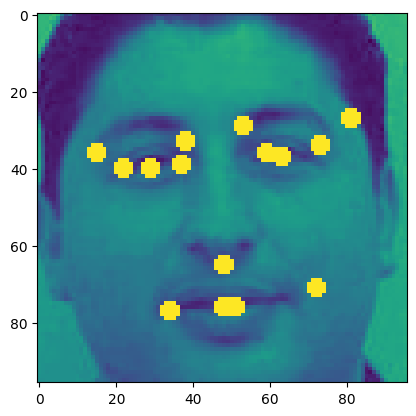

In [34]:
all_points = list() 
for i in range(0, 30, 2):
    points = (pred_int[i], pred_int[i+1])
    all_points.append(points)

image = X_test[0]
for point in all_points:
    image = cv2.circle(image, point, 1, (255, 0, 0), 2)
plt.imshow(image)